# Portafolios de Inversión
## Repaso Práctico
José Armando Melchor Soto

---





### Librerías 

In [19]:
import pandas as pd 
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from scipy.optimize import minimize 

---

#### Funciones

##### Función Mínima Varianza 

In [20]:
def opt_min_var(rets):
    
    cov=rets.cov()
    n_assets = len(rets.columns)
    
    var = lambda w: w.T @ cov @ w
    
    w0=np.ones(n_assets)/n_assets
    
    bounds=[(0, 1)]*n_assets
    
    constraint=lambda w: sum(w)-1
    
    result=minimize(fun=var, x0=w0, bounds=bounds, constraints={'fun': constraint, 'type': 'eq'}, tol=1e-16)
    
    return result.x

##### Función Máximo de Sharpe

In [21]:
def opt_max_sharpe(rets, rf):
    
    E=rets.mean()
    cov=rets.cov()
    n_assets = len(rets.columns)
    
    rs = lambda w: -((w.T @ E - rf/252) / np.sqrt(w.T @ cov @ w))
    
    w0=np.ones(n_assets)/n_assets
    
    bounds=[(0, 1)]*n_assets
    
    constraint=lambda w: sum(w)-1
    
    result=minimize(fun=rs, x0=w0, bounds=bounds, constraints={'fun': constraint, 'type': 'eq'}, tol=1e-16)
    
    return result.x

##### Función Semi-Varianza Target

In [22]:
def objetivo (rets:pd.DataFrame , rets_b : pd.DataFrame ,corr:pd.DataFrame):
    
    rets, rets_b = rets.align(rets_b, join='inner', axis=0)
    diffs=rets - rets_b.values
    rends_below_bench = diffs[diffs < 0].fillna(0)
    target_downside_risk=np.array(rends_below_bench.std())
    target_semivarmatrix= corr * (target_downside_risk.reshape(len(rets.columns), 1) @ target_downside_risk.reshape(1, len(rets.columns)))

    objectivo = lambda w: (w.T @ target_semivarmatrix @ w)

    n = len(rets.keys())
    w_inicial = np.ones(n)/n
    bounds = [(0,1)]*n
    tol = 1e-9
    rest = lambda w: np.sum(w) - 1
    
    obj = minimize(
    fun=objectivo,
    x0=w_inicial,
    bounds=bounds,
    constraints={'fun': rest, 'type': 'eq'},
    tol=tol)

    w_objetivo = obj.x

    return dict(zip(rets.columns, w_objetivo))

#### Función de Backtesting

In [ ]:
def backtesting(prices: pd.DataFrame, benchmark: pd.DataFrame, weights: dict, capital: float):
    
    # Obtener rendimientos de precios y benchmark
    rets_assets = prices.pct_change().dropna()
    rets_benchmark = benchmark.pct_change().dropna()
    
    # data frame vacio para llenar historia
    
    df = pd.DataFrame(index=rets_assets.index)
    
    # Obtener evolución para cada estrategia dada
    for strategy in weights.keys():
        # para benchmark
        if strategy == 'benchmark':
            temp = rets_benchmark + 1
            temp.iloc[0]=capital
            temp = temp.cumprod()
            df[strategy] = temp.values            
    
        # para otras estrategias

        else:
            temp = (rets_assets * weights.get(strategy)).sum(axis=1)+1
            temp.iloc[0]=capital
            temp = temp.cumprod()
            df[strategy] = temp.values    

    # Graficar la evolucion para ambos portafolios
    plt.figure(figsize=(12,6))
    plt.plot(df, label=df.keys())
    plt.title('Backtesting of Strategies')
    plt.xlabel('Date')
    plt.ylabel('Portafolio Value')
    plt.legend()
    plt.show()


    return df

##### Función Metricas de Desempeño

In [53]:
def metrics (history, rf:float):
    # Returns
    rets = history.pct_change().dropna()

    # Matriz Cov 
    cov = rets.cov()

    # Dataframe
    df = pd.Dataframe(index = rets.index)

    # Rendimiento
    df['Rendimiento']=r_p = rets.mean()
    # Volatilidad
    df['Volatilidad']=vol = rets.std()

    # Ratio de Sharpe
    df['Ratio Sharpe'] = R_S = (r_p-rf)/vol 

    # Downside Risk
    df['Downside Risk'] = downside =  rets[rets < 0].std() 

    # Upside Risk
    df['Upside Risk'] = upside = rets[rets>0].std()

    # Omega
    df['Omega'] = omega = downside/upside
    # Beta
    covs = cov_hist['Benchmark']
    varianza_market = covs['Benchmark']
    df['Beta'] = beta = covs/varianza_market
    # Alpha Jensen
    r_m = rets['Benchmark']
    df['Alpha Jensen'] = r_p - (rf+beta*(r_m-rf))
    # Ratio de Traynor
    df['Ratio de Traynor'] = (r_p - rf)/beta
    # Ratio de Sortino
    df['Ratio de Sortino'] = (r_p - rf)/downside

    return metrics.T

---

#### Importación de Datos

In [38]:
tickers = ['LIVEPOLC-1.MX', 'KOFUBL.MX', 'CEMEXCPO.MX', 'CHDRAUIB.MX', 'CUERVO.MX', 'LABB.MX', 'RA.MX']

opt_prices = yf.download(tickers, start='2023-06-23', end='2024-06-23', progress=False)['Close']

bt_prices = yf.download(tickers,  start='2024-06-23', end='2025-06-23', progress=False)['Close']

benchmark = yf.download(['^MXX'], start='2024-06-23', end='2025-06-23', progress=False)['Close']

In [46]:
rets = opt_prices.pct_change().dropna()
rets_b = benchmark.pct_change().dropna()
corr = rets.corr()

---

#### Mínima Varianza 

In [57]:
w_minvar = opt_min_var(rets)
w_minvar

array([0.04611899, 0.30905647, 0.11713476, 0.21646736, 0.00143757,
       0.24717853, 0.06260633])

#### Máximo de Sharpe

In [58]:
w_maxsharpe = opt_max_sharpe(rets,0.045)
w_maxsharpe

array([1.50698926e-17, 5.37796375e-01, 6.12923438e-17, 2.79535780e-20,
       9.00643729e-02, 3.72139252e-01, 7.84926325e-21])

#### Semi Varianza Target

In [59]:
w_semivar = objetivo(rets, rets_b, corr)
w_semivar

{'CEMEXCPO.MX': 0.14285714285714285,
 'CHDRAUIB.MX': 0.14285714285714285,
 'CUERVO.MX': 0.14285714285714285,
 'KOFUBL.MX': 0.14285714285714285,
 'LABB.MX': 0.14285714285714285,
 'LIVEPOLC-1.MX': 0.14285714285714285,
 'RA.MX': 0.14285714285714285}

#### Backtesting

In [62]:
capital = 1000000

In [63]:
w_dict = {
    'Min Varianza': w_minvar,
    'Max Sharpe': w_maxsharpe,
    'Semi-Varianza target': w_semivar,
    'Benchmark': 1
}

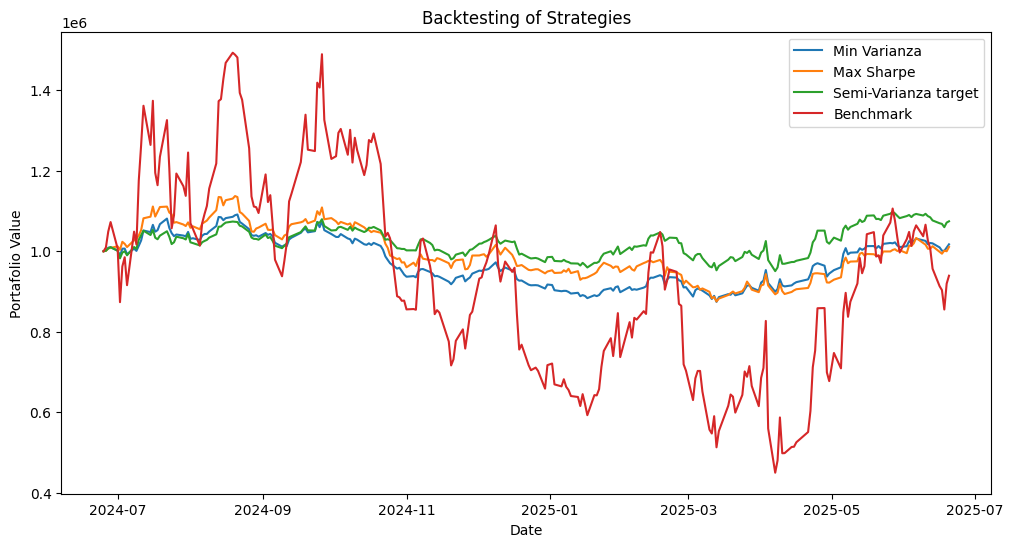

In [64]:
history = backtesting(bt_prices, benchmark, w_dict, capital)

---

#### Con diferentes activos

In [ ]:
tickers = ['LLY', 'ISRG', 'ABBV', 'JNJ', 'MRK']

In [71]:
opt_prices = yf.download(tickers, start='2023-06-23', end='2024-06-23', progress=False)['Close']

bt_prices = yf.download(tickers,  start='2024-06-23', end='2025-06-23', progress=False)['Close']

benchmark = yf.download(['VDC'], start='2024-06-23', end='2025-06-23', progress=False)['Close']

In [72]:
rets = opt_prices.pct_change().dropna()
rets_b = benchmark.pct_change().dropna()
corr = rets.corr()

---

#### Mínima Varianza 

In [73]:
w_minvar = opt_min_var(rets)

#### Máximo de Sharpe

In [74]:
w_maxsharpe = opt_max_sharpe(rets, 0.045)

#### Semi Varianza Target

In [75]:
w_semivar = objetivo(rets, rets_b, corr)

#### Backtesting

##### Capital

In [76]:
capital = 1000000

In [79]:
w_dict= {
    'Min Var' : w_minvar,
    'Max Sharpe': w_maxsharpe,
    'Semi Var': w_semivar,
    'Benchmark': 1
}

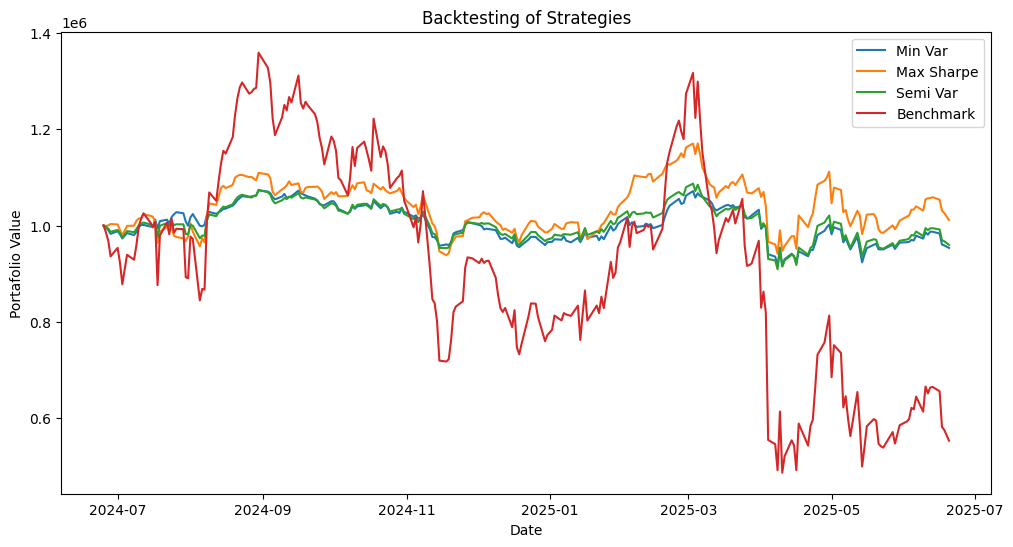

In [80]:
history = backtesting(bt_prices,benchmark, w_dict, capital )

In [81]:
metrics = metrics(history, 0.045)

AttributeError: module 'pandas' has no attribute 'Dataframe'

c